In [8]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
from time import time
from sklearn.metrics import pairwise_distances
from pyemd import emd
from gensim.corpora import Dictionary
from gensim.corpora.bleicorpus import BleiCorpus
from gensim.models.fasttext import load_facebook_vectors

In [2]:
# get logger
logging.basicConfig(level = os.environ.get("LOGLEVEL", "INFO"))
logger = logging.getLogger("similarity-graph")

In [3]:
def timeit(method):
    def timed(*args, **kw):
        ts = time()
        result = method(*args, **kw)
        te = time()
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            logger.info('%r  %2.2f [s]' % (method.__name__, (te - ts)))
        return result
    return timed

# 1. Load Data

In [4]:
logger.info("***Loading Data***")

# load args
with open("../args.json", "r") as f:
    args = json.load(f)

path_corpus = f'{args["corpus"]}{args["slice_type"]}'
dict_files = sorted([file for file in os.listdir(path_corpus) if ".dict" in file])
path_models = f'{args["results"]}hdp/{args["slice_type"]}'
models_dir = sorted(os.listdir(path_models))

slices = range(1, len(models_dir)+1)
data = {}
for slice in slices:
    # load dictionary {word->id}
    path_dict = f'{path_corpus}/{dict_files[slice-1]}'
    token2id = Dictionary.load(path_dict).token2id

    # load topics distributions
    path_topics = f'{path_models}/{models_dir[slice-1]}/mode-topics.dat'
    with open(path_topics, "r") as f:
        topics = np.array([[int(word) for word in line.strip().split()] for line in f])
    topics_dists = (topics.T/topics.sum(axis=1)).T

    #save data in a dict
    data[slice] = {"token2id": token2id, "topics_dists": topics_dists}

INFO:similarity-graph:***Loading Data***
INFO:gensim.utils:loading Dictionary object from ../data/corpus/year/dictionary_1.dict
INFO:gensim.utils:loaded ../data/corpus/year/dictionary_1.dict
INFO:gensim.utils:loading Dictionary object from ../data/corpus/year/dictionary_2.dict
INFO:gensim.utils:loaded ../data/corpus/year/dictionary_2.dict
INFO:gensim.utils:loading Dictionary object from ../data/corpus/year/dictionary_3.dict
INFO:gensim.utils:loaded ../data/corpus/year/dictionary_3.dict
INFO:gensim.utils:loading Dictionary object from ../data/corpus/year/dictionary_4.dict
INFO:gensim.utils:loaded ../data/corpus/year/dictionary_4.dict
INFO:gensim.utils:loading Dictionary object from ../data/corpus/year/dictionary_5.dict
INFO:gensim.utils:loaded ../data/corpus/year/dictionary_5.dict
INFO:gensim.utils:loading Dictionary object from ../data/corpus/year/dictionary_6.dict
INFO:gensim.utils:loaded ../data/corpus/year/dictionary_6.dict


# 2. Topic distributions

In [5]:
@timeit
def cum_dist_plot(array, quantiles = [0.6, 0.8, 0.9, 0.95, 0.99], figsize=(16,9)):
    
    #cumulative distribution
    serie = pd.Series(array)
    serie_sorted = serie.sort_values(ascending=False)
    indexs = range(1, len(serie_sorted)+1)
    cum_dist = []

    cum = 0
    for value in serie_sorted:
        cum += value
        cum_dist.append(cum)

    cum_dist = pd.Series(cum_dist)
    #quantiles
    q_indexs = [] 
    q_cum = [] 

    labels = [f"q{int(100*q)}" for q in quantiles] 
    for q in quantiles:
        cut = cum_dist.max()*q
        slice = cum_dist[cum_dist<cut]
        i, value = slice.index[-1], slice.values[-1]
        q_indexs.append(i)
        q_cum.append(value)

    #plot cdf
    fig, ax = plt.subplots(figsize=figsize)        
    ax.plot(indexs, cum_dist)

    #plot quantiles
    ax.scatter(q_indexs, q_cum)
    for i, label in enumerate(labels):
        ax.annotate(label, (q_indexs[i], q_cum[i]))    
    print(q_indexs, q_cum)
    return ax

INFO:similarity-graph:'cum_dist_plot'  0.04 [s]


[33, 141, 366, 710, 1487] [0.5979304802089611, 0.7998995378742206, 0.8997990757484445, 0.9499296765119659, 0.989993972272477]


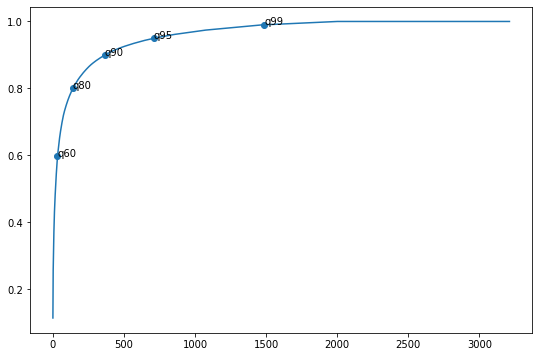

In [9]:
cum_dist_plot(data[1]["topics_dists"][0], quantiles = [0.6, 0.8, 0.9, 0.95, 0.99], figsize=(9,6))

In [37]:
def get_quantile(array, q):
    """
    Get number of elements that represent the 100q% of cumulative distribution of an array.
    """
    #cumulative distribution
    serie = pd.Series(array)
    serie_sorted = serie.sort_values(ascending=False)
    indexs = range(1, len(serie_sorted)+1)
    cum_dist = []

    cum = 0
    for value in serie_sorted:
        cum += value
        cum_dist.append(cum)

    cum_dist = pd.Series(cum_dist)
    
    #get quantile 
    cut = cum_dist.max()*q
    tail = np.array(cum_dist[cum_dist<=cut])
    if len(tail)>=1:
        quantile = np.argmax(tail)+1
    else:
        quantile = 1
    
    return quantile

In [38]:
q95_list = []
for slice in slices:
    topics = data[slice]["topics_dists"]
    topics.shape
    for i, topic in enumerate(topics):
        q95 = get_quantile(topic, 0.95)
        q95_list.append({"slice":slice, "topic":i, "vocabulary_size": len(topic),
                         "%q95":round(100*q95/len(topic),2)})

In [39]:
df_q95 = pd.DataFrame(q95_list)
df_q95.head()

,slice,topic,vocabulary_size,%q95
0,1,0,3212,22.14
1,1,1,3212,13.51
2,1,2,3212,27.99
3,1,3,3212,23.75
4,1,4,3212,33.72


In [13]:
df_q95[["slice", "vocabulary_size", "%q95"]].groupby("slice").describe()

vocabulary_size                                                       \
                count    mean  std     min     25%     50%     75%     max   
slice                                                                        
1                 5.0  3212.0  0.0  3212.0  3212.0  3212.0  3212.0  3212.0   
2                 9.0  3397.0  0.0  3397.0  3397.0  3397.0  3397.0  3397.0   
3                11.0  3653.0  0.0  3653.0  3653.0  3653.0  3653.0  3653.0   
4                 6.0  3934.0  0.0  3934.0  3934.0  3934.0  3934.0  3934.0   
5                 8.0  4056.0  0.0  4056.0  4056.0  4056.0  4056.0  4056.0   
6                 9.0  4065.0  0.0  4065.0  4065.0  4065.0  4065.0  4065.0   

       %q95                                                                
      count       mean        std    min      25%     50%      75%    max  
slice                                                                      
1       5.0  24.222000   7.478541  13.51  22.1400  23.750  27.9900  33.72  
2       9.0  11.317778  12.998381   0.03   0.4400   2.650  20.6700  29.67  
3      11.0  10.486364  11.907571   0.16   0.7650   4.740  21.7500  29.89  
4       6.0  16.806667  12.311717   0.03   7.9075  18.365  26.1150  30.96  
5       8.0  12.413750  12.654812   0.15   1.1500  11.205  21.0425  31.76  
6       9.0  12.730000  10.460477   0.02   1.8500  15.450  22.2400  25.12

In [14]:
df_q95["%q95"].describe()

count    48.000000
mean     13.605000
std      11.800624
min       0.020000
25%       0.887500
50%      14.480000
75%      23.667500
max      33.720000
Name: %q95, dtype: float64

In [80]:
df_q95["%q95"].quantile([0.6, 0.7, 0.8, 0.9, 0.95, 0.99])

0.60    20.6440
0.70    22.2350
0.80    24.7040
0.90    29.0120
0.95    30.5855
0.99    32.7988
Name: %q95, dtype: float64





* Nota: Analysis resultados preliminares para dhdp con slice_type='quarter'

Las conclusiones preliminares indican que en promedio con un 16% del vocabulario se puede capturar un 95% de la distribución acumulada de los tópicos. Además, para un 99% de los tópicos basta con un 37% del vocabulario para capturar el 95% de su distribución acumulada. Por tanto, una representación incompleta de los tópicos usando las palabras más probables que capturan el 95% de la cdf trae consigo una disminución importante en el tamaño del vocabulario, y por ende de los parámetros del EMD.

EL tamaño de los parámetros de EMD son (`fist_histogram(N), second_histogram(N), distance_matrix(NxN)`), luego la matriz de distancias es a lo más un 7.3%  de la matriz de distancia original. El poliedro del EMD es $Ax=b, x>=0$, con $A \in \mathbb{R}^{2N\times N^{2}}, b \in \mathbb{R}^{N}, x \in \mathbb{R}^{N^{2}}$.

Otra ventaja de reducir el tamaño de los tópicos es que el parámetro $b$ del poliedro es menos sparse y por ende es más estable numéricamente.

# 3. Distances

In [20]:
@timeit
def wmd(embeddings, token2id1, token2id2, topic1, topic2, q=None):
    """
    Input
        embeddings: gensim.models.keyedvectors.FastTextKeyedVectors, 
            words embeddings.
        token2id1: dict[str->int], 
            mapping between tokens and ids from topic 1.
        token2id2: dict[str->int], 
            mapping between tokens and ids from topic 2.
        topic1: numpy.array[float64], 
            distribution from topic 1.
        topic2: numpy.array[float64], 
            distribution from topic 2.
        q: float64, optional, 
            quantile rate between [0-1], used to filter words with less probability in a topic.
            represents the top N most likely words in a topic, such that its cumulative distribution 
            adds up to q.
    Output
        distance: float64
            word movers distance between two topics.
    """
    
    if q:
        # get quantiles 
        q1 = get_quantile(topic1, q) 
        q2 = get_quantile(topic2, q)
        # get indexs of useful tokens
        index1 = pd.Series(topic1).sort_values(ascending=False).index[0:q1]
        index2 = pd.Series(topic2).sort_values(ascending=False).index[0:q2]
        # map id->token
        id2token1 = {v: k for k, v in token2id1.items()}
        id2token2 = {v: k for k, v in token2id2.items()}
        # get vocabulary from union of topic vocabularies
        vocabulary1 = set([id2token1[i] for i in index1])
        vocabulary2 = set([id2token2[i] for i in index2])
        vocabulary = vocabulary1.union(vocabulary2)
    else:
        # get vocabulary from union of topic vocabularies
        vocabulary1 = set(token2id1.keys())
        vocabulary2 = set(token2id2.keys())
        vocabulary = vocabulary1.union(vocabulary2)
    # topics distributions with padding
    first_histogram = np.array([topic1[token2id1[word]] if word in vocabulary1 else 0 for word in vocabulary])
    second_histogram = np.array([topic2[token2id2[word]] if word in vocabulary2 else 0 for word in vocabulary])    
    # compute euclidean distance matrix between vocabulary words
    vocabulary_array = np.array([embeddings[word] for word in vocabulary])
    distance_matrix = pairwise_distances(X=vocabulary_array, metric="euclidean", n_jobs=-1)
    distance_matrix = distance_matrix.astype("float64")
    distance_matrix = distance_matrix.copy(order="C")
    # compute Earth Mover Distances
    distance = emd(first_histogram, second_histogram, distance_matrix)
    return distance

In [17]:
logger.info("***Loading Embeddings***")

embeddings = load_facebook_vectors(args["embeddings"])

INFO:similarity-graph:***Loading Embeddings***
INFO:gensim.models._fasttext_bin:loading 855380 words for fastText model from fasttext-sbwc.bin
INFO:gensim.models.word2vec:resetting layer weights
INFO:gensim.models.word2vec:Updating model with new vocabulary
INFO:gensim.models.word2vec:New added 855380 unique words (50% of original 1710760) and increased the count of 855380 pre-existing words (50% of original 1710760)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 855380 items
INFO:gensim.models.word2vec:sample=0.0001 downsamples 582 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 1489095212 word corpus (106.9% of prior 1392829209)
INFO:gensim.models.fasttext:loaded (2855380, 300) weight matrix for fastText model from fasttext-sbwc.bin


In [24]:
token2id1 = data[1]["token2id"]
token2id2 = data[2]["token2id"]
topic1 = data[1]["topics_dists"][0]
topic2 = data[2]["topics_dists"][0]

In [81]:
%time wmd(embeddings, token2id1, token2id2, topic1, topic2, q=None)

INFO:similarity-graph:'wmd'  933.38 [s]


CPU times: user 15min 34s, sys: 2.04 s, total: 15min 37s
Wall time: 15min 33s


2.9235794300288065

In [82]:
%time wmd(embeddings, token2id1, token2id2, topic1, topic2, q=0.8)

INFO:similarity-graph:'wmd'  0.58 [s]


CPU times: user 1.04 s, sys: 124 ms, total: 1.17 s
Wall time: 579 ms


2.4880156991813736